<a href="https://colab.research.google.com/github/neuralnetworksrs/Tarea-2/blob/master/Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Aplicaciones Recientes de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

**Temas**  

* Diseño e implementación detallado de Redes Recurrentes (RNN) y sus derivados.
* Compuertas LSTM y GRU. 
* Arquitectura Encoder-Decoder para problemas de *traducción*.
* Arquitectura de Autoencoder para reducción de dimensionalidad.
* Modelos generativos profundos: VAEs (*Variational Autoencoder*)

** Formalidades **  
* Equipos de trabajo de: 2-3 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: por definir.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF395-I-2019]

  


<a id="segundo"></a>
## 2. Encoder-Decoder sobre imágenes
---
En la presente seccion se experimentará con arquitecturas del tipo *encoder-decoder* [[3]](#refs) aplicadas sobre imágenes, tales como *image translation*, *object location*, *image segmentation*, entre otros. La idea es aplicar una red convolucional en ambas partes del modelo (encoder y decoder), así utilizamos un modelo que se adapte a estos casos.

La tarea consistirá en realizar **Image Segmentation** [[4]](#refs) para identificar ciertos segmentos o regiones de interés en una imagen a través de procesar de manera semántica (en la codificación) si cada pixel corresponde a un segmento a destacar. Esta tarea puede ser aplicada tanto para identificar un segmento como para identificar múltiples segmentos a través de colocar varios canales/filtros de salida en el *decoder*. Para ésto trabajaremos con un dataset creado en el área (*A BENCHMARK FOR SEMANTIC IMAGE SEGMENTATION*). El dataset resulta bastante pequeño en cantidad de datos, por lo que deberá pensar en formas de conllevar ésto.

<img src="https://qph.fs.quoracdn.net/main-qimg-78a617ec1de942814c3d23dab7de0b24" width="70%" />

Descargue los datos a través del siguiente __[link](http://www.ntu.edu.sg/home/ASJFCai/Benchmark_Website/benchmark_index.html)__. Luego cargue las pocas imágenes a trabajar con la librería __[Pillow](pillow.readthedocs.io)__. Debido a la dimensionalidad variable de los datos de entrada deberá redimensionar a un valor que considere prudente, *se aconseja menos de 250*, comente su decisión.


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [0]:
import numpy as np
import os
img_size = 128
folder = "/content/gdrive/My Drive/Colab Notebooks/Redes Neuronales/Tarea2/Semantic_dataset100"
data = [archivo.split(".")[0] for archivo in os.listdir(folder+"/image")]
from PIL import Image
X_image = []
for archivo in data:
    I = Image.open(folder+"/image/"+archivo+".jpg")
    I = np.asarray(I.resize( (img_size,img_size),Image.ANTIALIAS ))
    X_image.append(I)
X_image = np.asarray(X_image)
Y_image = []
for archivo in data:
    I = Image.open(folder+"/ground-truth/"+archivo+".png")
    I = np.asarray(I.resize( (img_size,img_size),Image.ANTIALIAS ))
    Y_image.append(I)
Y_image = np.asarray(Y_image)

Se descargaron desde el repositorio y se cargaron las imágenes utilizando la librería Pillow, con un total de solo 100 imágenes, y sus 100 respectivas segmentaciones. Se hizo una redimensión de las imágenes a 128x128 con el objetivo de que todas las imágenes tuvieran la misma dimensionalidad.

a) Explore los datos a trabajar, visualice la entrada y salida del modelo, además de las dimensionalidades de éstas ¿Es un problema las dimensiones de los datos *versus* la cantidad de datos a entrenar? Normalice los datos como se acostumbra en imágenes y genere una dimensión/canal extra a la salida.

In [0]:
X_image.shape

(100, 128, 128, 3)

In [0]:
def images_grid(images, grid_shape):
  grid = ImageGrid(plt.gcf(), 111, grid_shape, axes_pad=0.07)
  for i, image in enumerate(images):
    grid[i].imshow(Image.fromarray(image))
    grid[i].axes.get_xaxis().set_visible(False)
    grid[i].axes.get_yaxis().set_visible(False)

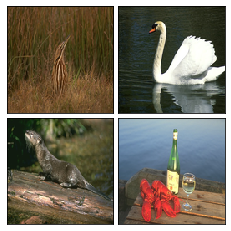

In [0]:
random_selection = np.random.choice(X_image.shape[0], 4, replace=False)
images_grid(X_image[random_selection, :], (2,2))

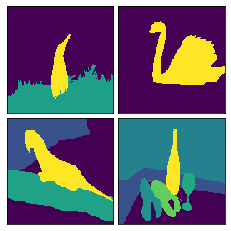

In [0]:
images_grid(Y_image[random_selection, :], (2,2))

In [0]:
X_image = X_image/255.
Y_image = Y_image/255.
Y_image = Y_image[:,:,:,None]

b) Separe 10 imágenes como conjunto de pruebas para verificar la calidad del modelo entrenado.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X_image, Y_image, test_size=0.1)

A pesar de que la cantidad de datos es pequeña, siempre es necesario tener una cantidad de imágenes considerables para realizar test sobre el modelo entrenado, en este caso se utiliza el $10%$ como test, por lo tanto, quedan 90 imágenes para entrenamiento y 10 imágenes para test seleccionadas aleatoriamente.

 c) Debido a la poca cantidad de datos presentes defina la arquitectura a utilizando únicamente convolucionales (*fully convolutional*) [[5]](#refs), como la presente en el código. Comente sobre los cambios en la dimensionalidad a través del *forward pass*. Decida el tamaño del *batch* en base a la cantidad de datos que se presenta para entrenar.

<center><img src="http://deeplearning.net/tutorial/_images/cat_segmentation.png" alt="drawing" width="450" />

Las redes totalmente convolucionales (FCN, del inglés fully convolutional networks) deben su nombre a su arquitectura, que se construye solo a partir de capas conectadas localmente, como convoluciones, pooling y upsampling. Una de sus características es que no se utiliza una capa densa en este tipo de arquitectura, lo que reduce el número de parámetros y el tiempo de cálculo.

Además, la red puede funcionar independientemente del tamaño de la imagen original, sin requerir un número fijo de unidades en ninguna etapa, dado que todas las conexiones son locales. 

Estas redes se utilizan mucho en el ámbito de la segmentación, la estrategia que éstas ocupan para obtener un mapa de segmentación (salida), generalmente tiene 2 partes:

 *  __Downsampling path__ : Captura la información semántica/contextual.
 * __Upsampling path__ : Recupera la información espacial.
 
El downsampling path se utiliza para extraer e interpretar el contexto (qué), mientras que el upsampling path se utiliza para permitir una localización precisa (dónde).


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization
model = Sequential()

#ENCODER PART
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=X_image.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

#DECODER PART
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same')) #pixel-wise classification
model.summary()
model.compile(loss='binary_crossentropy',optimizer='rmsprop')
train_histogram = model.fit(X_train,Y_train,epochs=100,batch_size=30, verbose = 0, validation_data=(X_test, Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 32, 32, 128)       73856     
__________

Se entrena el conjunto de entrenamiento, se utiliza un batch size de $30$, para un total de 100 epoch. Se hicieron pruebas con mayor cantidad de epoch pero aproximadamente desde la epoch 100 en adelante se producía un gran over-fitting en el entrenamiento.

In [0]:
def loss_by_epoch(hist):
  plt.figure(figsize=(16,4))
  plt.title('Train and Test')
  epochs = [i + 1 for i in range(100)]
  plt.plot(epochs, hist.history['loss'], '-o')
  plt.plot(epochs, hist.history['val_loss'], '-o')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train','Test'],loc='upper right')
  plt.show()

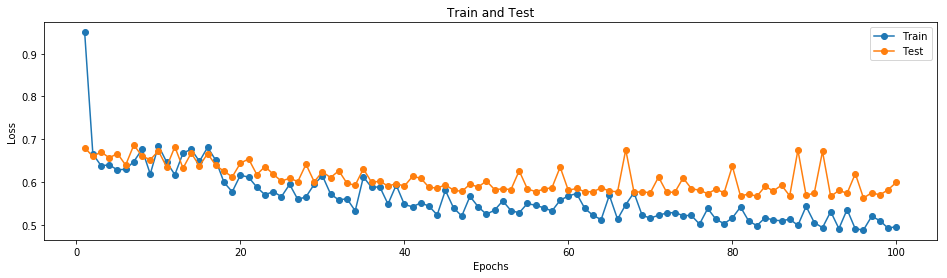

In [0]:
loss_by_epoch(train_histogram)

Al rededor de la epochs ~80 se empieza a notar una tendencia al over-fitting, esto es posible a la poca cantidad de datos con los que se trabaja.

d) Para medir el desempeño del modelo sobre ambos conjuntos realice un análisis cualitativo en base a visualizar la segmentación que realiza *versus* la segmentación real, además de verificar el *precision* y *recall* asumiendo valores binarios de pixel ¿Qué valor debería ser más importante los ceros o 1? Comente.

In [0]:
random_selection = np.random.choice(Y_train.shape[0], 10, replace=False)

Y_hat_train = np.squeeze( model.predict(X_train) )
Y_hat_test = np.squeeze( model.predict(X_test) )

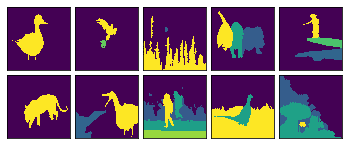

In [0]:
DN_Y_train = np.squeeze( Y_train )
images_grid(DN_Y_train[random_selection, :], (2,5))

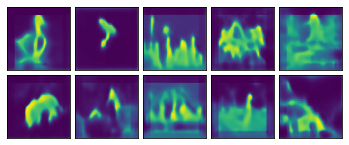

In [0]:
images_grid(Y_hat_train[random_selection, :], (2,5))

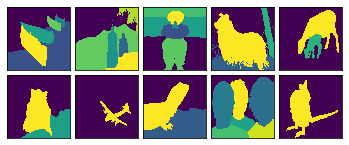

In [0]:
DN_Y_test = np.squeeze( Y_test )
images_grid(DN_Y_test, (2,5))

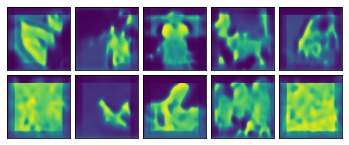

In [0]:
images_grid(Y_hat_test, (2,5))

En la comparación visual con los datos de entrenamiento se puede apreciar que al menos reconoce ciertas formas semejantes en la mayoría de los casos a las segmentaciones esperadas.

A diferencia del anterior, en la comparación visual con los datos de prueba solo en algunos casos logra generar formas similares a las reales, y en muchos de los otros no logra distinguir entre la figura y el fondo.


Respecto a la consideración entre ceros y unos, se consideran más importantes los 1 ya que es donde posiblemente se encontrarán los sectores de intereses que se busca segmentar. No obstante, también es necesario considerar que los pixeles del tipo cero, ya que, si se clasifican con valor uno, es decir un falso positivo, se estarían considerando pixeles que no son parte de la figura a segmentar.

In [0]:
from sklearn.metrics import precision_score, recall_score
Y_label = Y_train.flatten() > 0.5
Y_hat_label = Y_hat_train.flatten() >0.5
print('Precision Score')
print(precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print('Recall Score')
print(recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))

Precision Score
[0.78092018 0.68988552]
Recall Score
[0.90438902 0.45602615]


e) Compárese con alguna técnica manual de *Image Segmentation*, comúnmente se sugiere considerar un *treshold* para activar o apagar un píxel. Experimente con utilizar *treshold* igual a la media o con otra técnica más inteligente basada en los histogramas de escala de grises, como se utilizan en *skimage*.

In [0]:
gray_X = 0.2125*X_image[:,:,:,0]+ 0.7154*X_image[:,:,:,1]+ 0.0721*X_image[:,:,:,2] #needed gray-scale

""" One option"""
val = gray_X.mean()  #or another statistical
""" Another option"""
from skimage import filters
val = filters.threshold_otsu(gray_X) 
mask = gray_X < val
X_segmented = mask*1

f) Experimente con realizar *data augmentation* sobre el problema. Debido a que las operaciones clásicas de *augmentation* como rotar, invertir, girar, cambiarian la etiqueta de segmentación, genere una estrategia que mantenga la etiqueta/salida $Y$. Se presenta un código de ejemplo, *Denoising*, de aplicar una máscara binaria aleatoria sobre la imagen de entrada $X$, **de todas formas se espera que proponga alguna distinta**. Compare el desempeño alcanzado con la nueva red con la forma de evaluar definida en (d).

Debido a la pequeña cantidad de imágenes en  el data set, se busca realizar *data augmentation* sobre las imágenes originales para aumentar la cantidad de datos de entrenamiento con el fin de mejorar tanto el Recall como la Precisión en el modelo.

In [0]:
from numpy.random import binomial #DENOISING IDEA
T = 100
for _ in range(T):
    noise_level = np.random.randint(4,10)/10.
    noise_mask = binomial(n=1,p=noise_level,size=X_image.shape)
    X_augmented = X_image*noise_mask
    model.fit(X_augmented,Y_image,epochs=10,batch_size=5,validation_data=(X_image,Y_image), verbose = 0)

In [0]:
random_selection = np.random.choice(Y_train.shape[0], 10, replace=False)

Y_hat_train = np.squeeze( model.predict(X_train) )
Y_hat_test = np.squeeze( model.predict(X_test) )

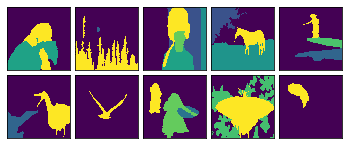

In [0]:
DN_Y_train = np.squeeze( Y_train )
images_grid(DN_Y_train[random_selection, :], (2,5))

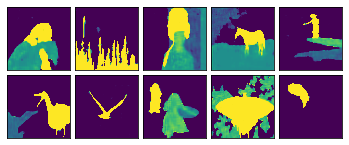

In [0]:
images_grid(Y_hat_train[random_selection, :], (2,5))

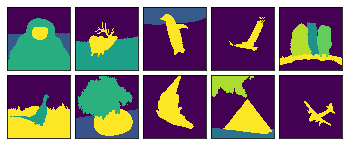

In [0]:
DN_Y_test = np.squeeze( Y_test )
images_grid(DN_Y_test, (2,5))

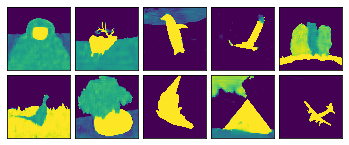

In [0]:
images_grid(Y_hat_test, (2,5))

In [0]:
from sklearn.metrics import precision_score, recall_score
Y_label = Y_train.flatten() > 0.5
Y_hat_label = Y_hat_train.flatten() >0.5
print('Precision Score')
print(precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print('Recall Score')
print(recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))

Precision Score
[0.97576956 0.98342128]
Recall Score
[0.99248807 0.94758938]


Con el código de ejemplo se llega a muy bueno resultados que se pueden apreciar claramente de forma cualitativa, además cuantitativamente hablando, tanto la precisión como el recall aumentan en gran medida respecto a la red básica de la sección c).

### Random Rotation



In [0]:
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

In [0]:
image_to_transform = []
for archivo in data:
    I = Image.open(folder+"/image/"+archivo+".jpg")
    I = np.asarray(I.resize( (img_size,img_size),Image.ANTIALIAS ))
    image_to_transform.append(I)
image_to_transform = np.asarray(image_to_transform)[0]

In [0]:
# dictionary of the transformations functions we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

# random num of transformations to apply
num_transformations_to_apply = random.randint(1, len(available_transformations))

num_transformations = 0
transformed_image = None
while num_transformations <= num_transformations_to_apply:
    # choose a random transformation to apply for a single image
    key = random.choice(list(available_transformations))
    transformed_image = available_transformations[key](image_to_transform)
    num_transformations += 1

g) Intente variar la arquitectura presentada en pos de obtener un mejor modelo, basado en la evaluación realizada en (d). Recuerde tomar en cuenta la poca cantidad de datos que se tiene.

<a id="refs"></a>
## Referencias
[1] https://es.wikipedia.org/wiki/Ley_de_Zipf    
[2] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). *Efficient estimation of word representations in vector space*. arXiv preprint arXiv:1301.3781.    
[3] Cho, K., Van Merriënboer, B., Bahdanau, D., & Bengio, Y. (2014). *On the properties of neural machine translation: Encoder-decoder approaches*. arXiv preprint arXiv:1409.1259.  
[4] Pal, N. R., & Pal, S. K. (1993). *A review on image segmentation techniques*. Pattern recognition, 26(9), 1277-1294.  
[5] Badrinarayanan, V., Kendall, A., & Cipolla, R. (2017). *Segnet: A deep convolutional encoder-decoder architecture for image segmentation*. IEEE transactions on pattern analysis and machine intelligence, 39(12), 2481-2495.  
[6] Papineni, K., Roukos, S., Ward, T., & Zhu, W. J. (2002, July). *BLEU: a method for automatic evaluation of machine translation*. In Proceedings of the 40th annual meeting on association for computational linguistics (pp. 311-318). Association for Computational Linguistics.  
[7] Kingma, D. P., & Welling, M. (2013). *Auto-encoding variational bayes*. arXiv preprint arXiv:1312.6114.  
[8] https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence     
[9] Dumoulin, V., & Visin, F. (2016). *A guide to convolution arithmetic for deep learning*. arXiv preprint arXiv:1603.07285.  also: https://github.com/vdumoulin/conv_arithmetic  
[10] Jang, E., Gu, S., & Poole, B. (2016). *Categorical reparameterization with gumbel-softmax*. arXiv preprint arXiv:1611.01144.  
[11] https://en.wikipedia.org/wiki/Cluster_analysis  